# Задача прогнозирования инсульта. Обучение полносвязной (неглубокой) нейронной сети.

In [1]:
import numpy as np              # Массивы (матрицы, векторы, линейная алгебра)
import matplotlib.pyplot as plt # Научная графика
%matplotlib inline 
    # Говорим jupyter'у, чтобы весь графический вывод был в браузере, а не в отдельном окне
    
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import sklearn                  # Алгоритмы машинного обучения

### Загрузка датасета и подготовка данных 

Подготовка данных как в задании ML_HW_1.

1. Заполнение пропущенных значений и обработка выбросов.
2. Замена бинарных признаков 'gender', 'ever_married' и 'Residence_type' на числовые.
3. К категориальным (небинарным) признакам 'work_type' 'smoking_status' применим метод бинаризации.
4. Нормализация количественных признаков 'age', 'avg_glucose_level','bmi'

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv', sep=',', header=0,  engine='python')

data=data.drop('id', axis=1)
data.fillna(data.median(axis = 0), axis=0 , inplace=True)
data = data.drop(data[(data['age'] <=30) & (data['stroke'] ==1)].index)
data.loc[data['gender']=='Other','gender']='Female' 

data.loc[data['gender'] == 'Female', 'gender'] = 1
data.loc[data['gender'] == 'Male', 'gender'] = 0
data.loc[data['ever_married'] == 'Yes', 'ever_married'] = 1
data.loc[data['ever_married'] == 'No', 'ever_married'] = 0
data.loc[data['Residence_type'] == 'Rural', 'Residence_type'] = 1
data.loc[data['Residence_type'] == 'Urban', 'Residence_type'] = 0

data = pd.get_dummies(data, columns=['work_type', 'smoking_status'])
data_numerical=data[['age', 'avg_glucose_level','bmi']]
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)

data=data.drop(['age', 'avg_glucose_level','bmi'], axis=1)
data=pd.concat([data, data_numerical], axis=1)

data

,gender,hypertension,heart_disease,ever_married,Residence_type,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,avg_glucose_level,bmi
0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,1.051035,2.705684,1.004831
1,1,0,0,1,1,1,0,0,0,1,0,0,0,1,0,0.785616,2.120938,-0.098920
2,0,0,1,1,1,1,0,0,1,0,0,0,0,1,0,1.626110,-0.005391,0.472433
3,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0.254778,1.436820,0.719154
4,1,1,0,1,1,1,0,0,0,1,0,0,0,1,0,1.581873,1.500639,-0.631318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1.626110,-0.494961,-0.098920
5106,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1.670346,0.420361,1.446332
5107,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,-0.364533,-0.511744,0.225713
5108,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0.343251,1.327733,-0.423553


### Разбиваем данные на обучающую и тестовую выборки

In [3]:
y = data['stroke']
X = data.drop(['stroke'], axis=1)

Разобьем данные на обучающую и тестовую выборки - 70% и 30%

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 40)

N_test, _ = X_test.shape
N_train, _ = X_train.shape 

N_test, N_train

(1533, 3575)

### Обучаем классификатор

In [5]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes = (100,),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          random_state = 40,
                          max_iter=3000)


In [6]:
%%time
mlp_model.fit(X_train, y_train)

Wall time: 1.95 s


MLPClassifier(activation='logistic', max_iter=3000, random_state=40,
              solver='lbfgs')

### Проверяем качество классификатора

In [7]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_train_pred)

1.0

In [8]:
accuracy_score(y_test, y_test_pred)

0.9145466405740378

### Подбор гиперпараметров

In [9]:
alpha_arr = np.logspace(-3, 2, 20)
test_err = []
train_err = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', 
                              activation = 'logistic', 
                              max_iter=3000, 
                              random_state = 40)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

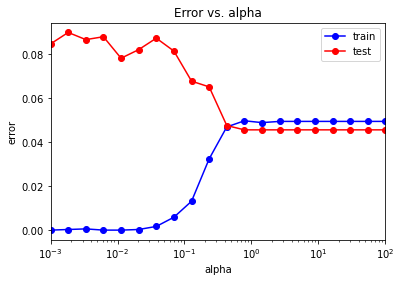

In [10]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

При alpha < ~0.78 наблюдается переобучение - ошибка на тестовой выборке значительно больше ошибки на тренировочной.

In [11]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print('Минимальное значение ошибки:',min_train_err, min_test_err)

Минимальное значение ошибки: 0.0 0.045662100456621


In [12]:
alpha_opt = alpha_arr[test_err == min_test_err][0]
print('Оптимальное значение alpha:',alpha_opt)

Оптимальное значение alpha: 0.7847599703514607


### Подбор количества нейронов

Подберем оптимальное количество нейронов в нейронной сети при оптимальном значении alpha

In [13]:
neuron_arr = (np.linspace(1, 300, 80)).astype(int)
test_err = []
train_err = []

for neuron in neuron_arr:
    mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (neuron,), 
                              solver = 'lbfgs', 
                              activation = 'logistic', 
                              max_iter=1000, 
                              random_state = 40)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

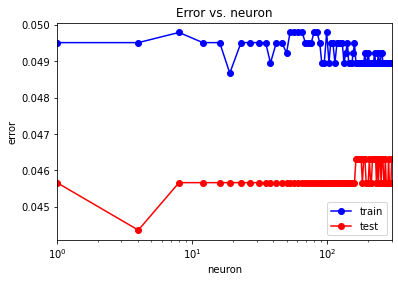

In [14]:
plt.semilogx(neuron_arr, train_err, 'b-o', label = 'train')
plt.semilogx(neuron_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(neuron_arr), np.max(neuron_arr)])
plt.title('Error vs. neuron')
plt.xlabel('neuron')
plt.ylabel('error')
plt.legend()

In [15]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print('Минимальное значение ошибки:',min_train_err, min_test_err)

Минимальное значение ошибки: 0.04867132867132867 0.04435746901500326


In [16]:
neuron_opt = neuron_arr[test_err == min_test_err][0]
print('Оптимальное количество нейронов:',neuron_opt)

Оптимальное количество нейронов: 4


### Классификатор при найденных параметрах (alpha и кол-во нейронов)

In [17]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (neuron_opt,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 40)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print('Итоговая точность:')
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

Итоговая точность:
0.9504895104895105
0.9556425309849967


### Матрица рассогласования:

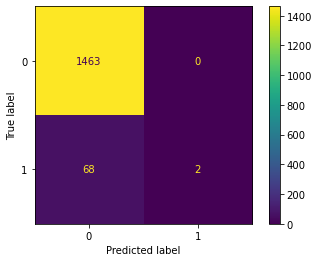

In [18]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mlp_model, X_test, y_test) 

### Выводы
1. Мы построили полносвязную (неглубокую) нейронную сеть с 1 скрытым слоем.
2. При подборе оптимальных параметров удалось устранить переобучение и повысить точность на тестовой выборке на ~4%.
